In [6]:
import pandas as pd
from textblob import TextBlob
import re
from nrclex import NRCLex
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

# Load the dataset
df = pd.read_csv("hf://datasets/sohvren/AmazonProductReviews/amazon_reviews.csv")

# Keep only the first 22,000 rows
df = df.head(22000)

# Drop missing values
df.dropna(inplace=True)

# Remove duplicates
df.drop_duplicates(subset='Text', inplace=True)

# Text preprocessing function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply text cleaning
df['cleaned_review'] = df['Text'].apply(clean_text)

# Sentiment analysis function
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis
df['sentiment_score'] = df['cleaned_review'].apply(get_sentiment)

# Categorizing sentiment
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# Emotion analysis function
def get_emotions(text):
    emotion_scores = NRCLex(text).affect_frequencies
    all_emotions = ['fear', 'anger', 'anticip', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy']
    return {emotion: emotion_scores.get(emotion, 0) for emotion in all_emotions}

# Apply emotion analysis
df['emotion_scores'] = df['cleaned_review'].apply(get_emotions)

# Convert JSON column into separate columns
emotion_df = df['emotion_scores'].apply(pd.Series)

# Merge with main dataframe
df = pd.concat([df, emotion_df], axis=1)

# Topic Modeling using LDA
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_review'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
df['topic'] = lda.fit_transform(X).argmax(axis=1)

# Clustering using Sentence-BERT and K-Means
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['cleaned_review'].tolist(), convert_to_numpy=True)
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

# **NEW: Reduce embeddings to 2D for Tableau visualization**
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Add to dataframe
df['pca_1'] = reduced_embeddings[:, 0]
df['pca_2'] = reduced_embeddings[:, 1]

# Save processed data for Tableau
output_file = "cleaned_amazon_reviews.csv"
df[['Text', 'cleaned_review', 'Score', 'sentiment_score', 'sentiment_category', 
    'fear', 'anger', 'anticip', 'trust', 'surprise', 'positive', 'negative', 
    'sadness', 'disgust', 'joy', 'topic', 'cluster', 'pca_1', 'pca_2']].to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")


Processed data saved to cleaned_amazon_reviews.csv


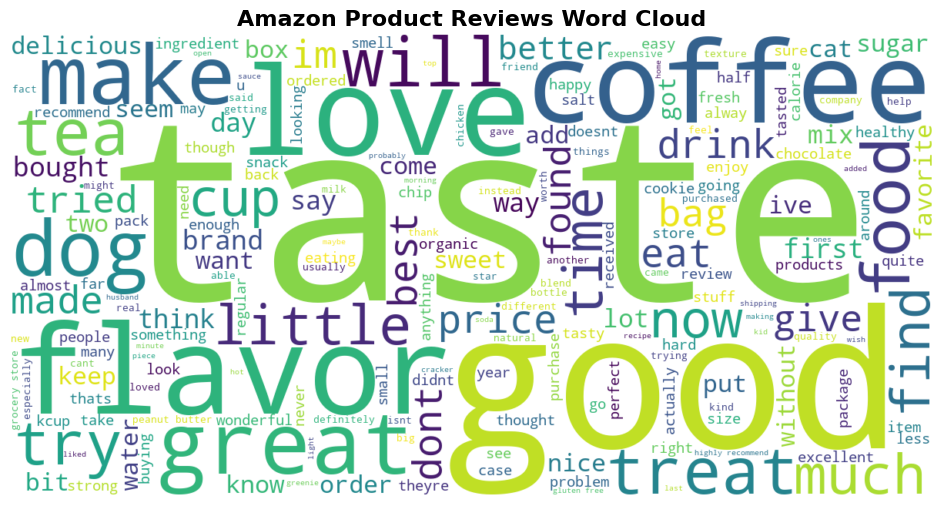

In [5]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Combine all reviews into a single text
all_text = " ".join(df['cleaned_review'])

# Define additional stopwords to remove
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["product", "amazon", "use", "used", "buy", "get", "one", "also", 
                         "like", "really", "bad", "would", "could", "thing", 
                         "use", "using", "well", "work", "works", "even", "still", "since", "br"])

# Generate Word Cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white', 
                      stopwords=custom_stopwords, colormap='viridis', 
                      max_words=200, contour_color='steelblue', contour_width=2).generate(all_text)

# Display the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Amazon Product Reviews Word Cloud", fontsize=16, fontweight='bold')
plt.show()
